# BBoxerwGradCAM

### This class forms boundary boxes (rectangle and polygon) using GradCAM outputs for a given image.

The purpose of this class is to develop Rectangle and Polygon coordinates that define an object based on an image classification model. The 'automatic' creation of these coordinates, which are often included in COCO JSONs used to train object detection models, is valuable because data preparation and labeling can be a time consuming task.

### This class takes 5 user inputs:
* **Pretrained Learner** (image classification model)
* **GradCAM Heatmap** (heatmap of GradCAM object - formed by a pretrained image classification learner)
* **Source Image**
* **Image Resizing Scale** (also applied to corresponding GradCAM heatmap)
* **BBOX Rectangle Resizing Scale**


*Class is compatible with google colab and other Python 3 enivronments*


In [0]:
# Imports for loading learner and the GradCAM class
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
import scipy.ndimage

The following cell contains the widely used GradCAM class for pretrained image classification models (unedited).

In [0]:
#@title GradCAM Class

class GradCam():
    @classmethod
    def from_interp(cls,learn,interp,img_idx,ds_type=DatasetType.Valid,include_label=False):
        # produce heatmap and xb_grad for pred label (and actual label if include_label is True)
        if ds_type == DatasetType.Valid:
            ds = interp.data.valid_ds
        elif ds_type == DatasetType.Test:
            ds = interp.data.test_ds
            include_label=False
        else:
            return None
        
        x_img = ds.x[img_idx]
        xb,_ = interp.data.one_item(x_img)
        xb_img = Image(interp.data.denorm(xb)[0])
        probs = interp.preds[img_idx].numpy()

        pred_idx = interp.pred_class[img_idx].item() # get class idx of img prediction label
        hmap_pred,xb_grad_pred = get_grad_heatmap(learn,xb,pred_idx,size=xb_img.shape[-1])
        prob_pred = probs[pred_idx]
        
        actual_args=None
        if include_label:
            actual_idx = ds.y.items[img_idx] # get class idx of img actual label
            if actual_idx!=pred_idx:
                hmap_actual,xb_grad_actual = get_grad_heatmap(learn,xb,actual_idx,size=xb_img.shape[-1])
                prob_actual = probs[actual_idx]
                actual_args=[interp.data.classes[actual_idx],prob_actual,hmap_actual,xb_grad_actual]
        
        return cls(xb_img,interp.data.classes[pred_idx],prob_pred,hmap_pred,xb_grad_pred,actual_args)
    
    @classmethod
    def from_one_img(cls,learn,x_img,label1=None,label2=None):
        '''
        learn: fastai's Learner
        x_img: fastai.vision.image.Image
        label1: generate heatmap according to this label. If None, this wil be the label with highest probability from the model
        label2: generate additional heatmap according to this label
        '''
        pred_class,pred_idx,probs = learn.predict(x_img)
        label1= str(pred_class) if not label1 else label1
        
        xb,_ = learn.data.one_item(x_img)
        xb_img = Image(learn.data.denorm(xb)[0])
        probs = probs.numpy()
        
        label1_idx = learn.data.classes.index(label1)
        hmap1,xb_grad1 = get_grad_heatmap(learn,xb,label1_idx,size=xb_img.shape[-1])
        prob1 = probs[label1_idx]
        
        label2_args = None
        if label2:
            label2_idx = learn.data.classes.index(label2)
            hmap2,xb_grad2 = get_grad_heatmap(learn,xb,label2_idx,size=xb_img.shape[-1])
            prob2 = probs[label2_idx]
            label2_args = [label2,prob2,hmap2,xb_grad2]
            
        return cls(xb_img,label1,prob1,hmap1,xb_grad1,label2_args)
    
    def __init__(self,xb_img,label1,prob1,hmap1,xb_grad1,label2_args=None):
        self.xb_img=xb_img
        self.label1,self.prob1,self.hmap1,self.xb_grad1 = label1,prob1,hmap1,xb_grad1
        if label2_args:
            self.label2,self.prob2,self.hmap2,self.xb_grad2 = label2_args
            
    def plot(self,plot_hm=True,plot_gbp=True):
        if not plot_hm and not plot_gbp:
            plot_hm=True
        cols = 5 if hasattr(self, 'label2') else 3
        if not plot_gbp or not plot_hm:
            cols-= 2 if hasattr(self, 'label2') else 1

        fig,row_axes = plt.subplots(1,cols,figsize=(cols*5,5))  
        col=0
        size=self.xb_img.shape[-1]
        self.xb_img.show(row_axes[col]);col+=1
        
        label1_title = f'1.{self.label1} {self.prob1:.3f}'
        if plot_hm:
            show_heatmap(self.hmap1,self.xb_img,size,row_axes[col])
            row_axes[col].set_title(label1_title);col+=1
        if plot_gbp:
            row_axes[col].imshow(self.xb_grad1)
            row_axes[col].set_axis_off()
            row_axes[col].set_title(label1_title);col+=1
        
        if hasattr(self, 'label2'):
            label2_title = f'2.{self.label2} {self.prob2:.3f}'
            if plot_hm:
                show_heatmap(self.hmap2,self.xb_img,size,row_axes[col])
                row_axes[col].set_title(label2_title);col+=1
            if plot_gbp:
                row_axes[col].imshow(self.xb_grad2)
                row_axes[col].set_axis_off()
                row_axes[col].set_title(label2_title)
        # plt.tight_layout()
        fig.subplots_adjust(wspace=0, hspace=0)
        # fig.savefig('data_draw/both/gradcam.png')

def minmax_norm(x):
    return (x - np.min(x))/(np.max(x) - np.min(x))
def scaleup(x,size):
    scale_mult=size/x.shape[0]
    upsampled = scipy.ndimage.zoom(x, scale_mult)
    return upsampled

# hook for Gradcam
def hooked_backward(m,xb,target_layer,clas):
    with hook_output(target_layer) as hook_a: #hook at last layer of group 0's output (after bn, size 512x7x7 if resnet34)
        with hook_output(target_layer, grad=True) as hook_g: # gradient w.r.t to the target_layer
            preds = m(xb)
            preds[0,int(clas)].backward() # same as onehot backprop
    return hook_a,hook_g

def clamp_gradients_hook(module, grad_in, grad_out):
    for grad in grad_in:
        torch.clamp_(grad, min=0.0)
        
# hook for guided backprop
def hooked_ReLU(m,xb,clas):
    relu_modules = [module[1] for module in m.named_modules() if str(module[1]) == "ReLU(inplace)"]
    with callbacks.Hooks(relu_modules, clamp_gradients_hook, is_forward=False) as _:
        preds = m(xb)
        preds[0,int(clas)].backward()
        
def guided_backprop(learn,xb,y):
    xb = xb.cuda()
    m = learn.model.eval();
    xb.requires_grad_();
    if not xb.grad is None:
        xb.grad.zero_(); 
    hooked_ReLU(m,xb,y);
    return xb.grad[0].cpu().numpy()

def show_heatmap(hm,xb_im,size,ax=None):
    if ax is None:
        _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.8, extent=(0,size,size,0),
              interpolation='bilinear',cmap='magma');

def get_grad_heatmap(learn,xb,y,size):
    '''
    Main function to get hmap for heatmap and xb_grad for guided backprop
    '''
    xb = xb.cuda()
    m = learn.model.eval();
    target_layer = m[0][-1][-1] # last layer of group 0
    hook_a,hook_g = hooked_backward(m,xb,target_layer,y)
    
    target_act= hook_a.stored[0].cpu().numpy()
    target_grad = hook_g.stored[0][0].cpu().numpy()
    
    mean_grad = target_grad.mean(1).mean(1)
#     hmap = (target_act*mean_grad[...,None,None]).mean(0)
    hmap = (target_act*mean_grad[...,None,None]).sum(0)
    hmap = np.where(hmap >= 0, hmap, 0)
    
    xb_grad = guided_backprop(learn,xb,y) # (3,224,224)        
    #minmax norm the grad
    xb_grad = minmax_norm(xb_grad)
    hmap_scaleup = minmax_norm(scaleup(hmap,size)) # (224,224)
    
    # multiply xb_grad and hmap_scaleup and switch axis
    xb_grad = np.einsum('ijk, jk->jki',xb_grad, hmap_scaleup) #(224,224,3)
    
    return hmap,xb_grad

I connect to google drive (this notebook was made on google colab for GPU usage) and load my pretrained learner.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
base_dir = '/content/drive/My Drive/fellowshipai-data/final_3_class_data_train_test_split'

def get_data(sz): # This function returns an ImageDataBunch with a given image size
  return ImageDataBunch.from_folder(base_dir+'/', train='train', valid='valid', # 0% validation because we already formed our testing set
        ds_tfms=get_transforms(), size=sz, num_workers=4).normalize(imagenet_stats) # Normalized, 4 workers (multiprocessing) - 64 batch size (default)

In [5]:
arch = models.resnet34
data = get_data(224)
learn = cnn_learner(data,arch,metrics=[error_rate,Precision(average='micro'),Recall(average='micro')],train_bn=True,pretrained=True).mixup()
learn.load('model-224sz-basicaugments-oversampling-mixup-dLRs')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

Learner(data=ImageDataBunch;

Train: LabelList (2295 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
raw,raw,raw,raw,raw
Path: /content/drive/My Drive/fellowshipai-data/final_3_class_data_train_test_split;

Valid: LabelList (580 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
raw,raw,raw,raw,raw
Path: /content/drive/My Drive/fellowshipai-data/final_3_class_data_train_test_split;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


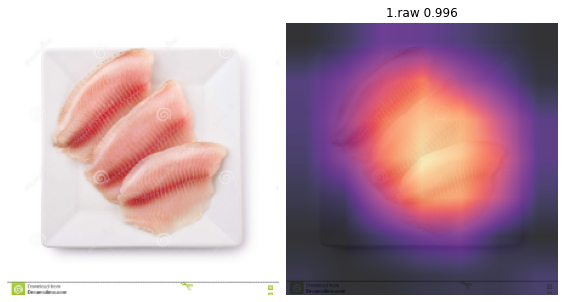

In [6]:
example_image = '/content/drive/My Drive/fellowshipai-data/final_3_class_data_train_test_split/train/raw/00000015.jpg'

img = open_image(example_image)

gcam = GradCam.from_one_img(learn,img) # using the GradCAM class

gcam.plot(plot_gbp = False) # We care about the heatmap (which is overlayed on top of the original image inherently)

gcam_heatmap = gcam.hmap1 # This is a 2d array

My pretrained learner correctly classified the image as raw with probability 0.996.

Note that images with very low noise and accurate feature importances (as with the example image) are 

The learner is focusing on the steak in center view (heatmap pixels indicate feature importance).

In [0]:
from BBOXES_from_GRADCAM import BBoxerwGradCAM # load class from .py file

In [0]:
image_resizing_scale = [400,300]
bbox_scaling = [1,1,1,1] 

bbox = BBoxerwGradCAM(learn,
                      gcam_heatmap,
                      example_image,
                      image_resizing_scale,
                      bbox_scaling)

In [9]:
for function in dir(bbox)[-18:]: print(function)

bbox_coords
contours
form_bboxes
get_bboxes
grey_img
heatmap
heatmap_smoothing
image_path
learner
og_img
poly_coords
resize_list
scale_list
show_bboxpolygon
show_bboxrectangle
show_contouredheatmap
show_smoothheatmap
smooth_heatmap


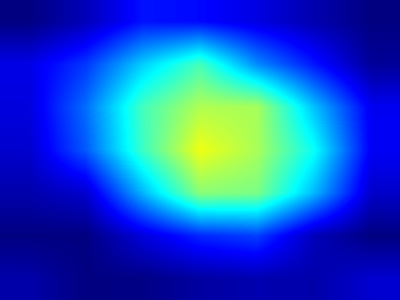

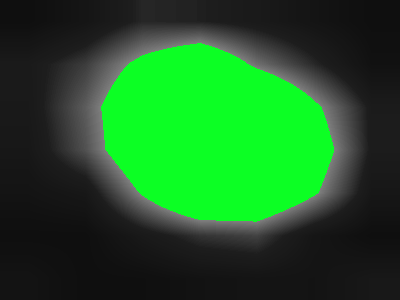

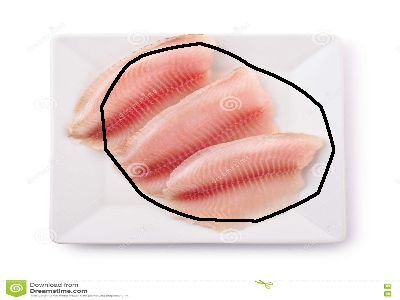

In [10]:
bbox.show_smoothheatmap()
bbox.show_contouredheatmap()
#bbox.show_bboxrectangle()
bbox.show_bboxpolygon()

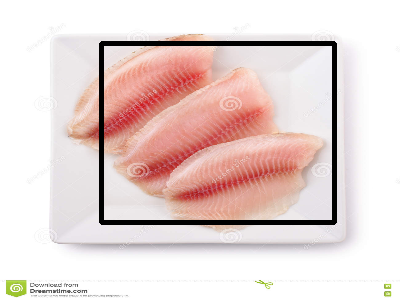

In [10]:
bbox.show_bboxrectangle()

In [0]:
rect_coords, polygon_coords = bbox.get_bboxes()

In [12]:
rect_coords # x,y,w,h

[101, 43, 233, 179]

In [13]:
polygon_coords

[array([[[197,  43]],
 
        [[196,  44]],
 
        [[190,  44]],
 
        [[189,  45]],
 
        ...,
 
        [[205,  45]],
 
        [[204,  44]],
 
        [[202,  44]],
 
        [[201,  43]]], dtype=int32)]

In [0]:
# IoU for object detection
def get_IoU(truth_coords, pred_coords):
    pred_area = pred_coords[2]*pred_coords[3]
    truth_area = truth_coords[2]*truth_coords[3]
    # coords of intersection rectangle
    x1 = max(truth_coords[0], pred_coords[0])
    y1 = max(truth_coords[1], pred_coords[1])
    x2 = min(truth_coords[2], pred_coords[2])
    y2 = min(truth_coords[3], pred_coords[3])
    # area of intersection rectangle
    interArea = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    # area of prediction and truth rectangles
    boxTruthArea = (truth_coords[2] - truth_coords[0] + 1) * (truth_coords[3] - truth_coords[1] + 1)
    boxPredArea = (pred_coords[2] - pred_coords[0] + 1) * (pred_coords[3] - pred_coords[1] + 1)
    # intersection over union 
    iou = interArea / float(boxTruthArea + boxPredArea - interArea)
    return iou

In [20]:
get_IoU([80,40,240,180],rect_coords)

0.8026518655565834